### **Nome:** Jhonatan Guilherme de Oliveira Cunha
### **RA:** 2135590

### **Trabalho de Aprendizado de Máquina**

Nosso objetivo aqui é responder a seguinte pergunta: "que pessoas tinham  mais chances de sobreviver ao naufrágio do Titanic".

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind_from_stats

%matplotlib inline

#### Logo abaixo realizamos a leitura de nossa base de dados *csv*, descartando atributos que não são importantes para a nossa análise (PassengerId e Name).

#### Obtemos o DataFrame **X** e nosso array de saída **y**

In [2]:
# O atributo "PassengerId" foi removido pelo fato do mesmo não interferir no resultado de nossa saída (Survived), 
# ou seja, o mesmo é um atributo criado somente para realizar a identificação de cada passageiro na base de dados

  
# O atributo "Name" foi removido pelo fato do mesmo não ser um dado significado para a análise desejada, ou seja,
# não é um atributo onde conseguiriamos encontrar um padrão ou associação, para treinar um melhor modelo.

In [3]:
df = pd.read_csv('train.csv')
df.drop(['PassengerId','Name'], axis=1, inplace=True)

y = df['Survived'].values.ravel()
X = df.drop('Survived', axis=1)

#### Como podemos visualizar abaixo, nosso DataFrame possui valores faltantes. Sendo assim, deveremos realizar a técnica de imputação de dados, com objetivo de realizar uma analise mais adequada em nossos dados.

In [4]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### 1. Limpe a base de dados. Nesta etapa você deve decidir o que fazer com as instâncias que possuem dados faltantes: preencher os dados faltantes de acordo com alguma regra? Descartar as instâncias que possuem dados faltantes?

In [5]:
# Campos imp_num (SimpleImputer strategy=mean): a estratégia de imputação de dados utilizada aqui, foi preencher os 
# campos vazios de cada coluna baseado na média dos valores de cada uma. A estrategia de média foi escolhida pois os valores 
# dessas colunas são atributos númericos.

# Campos cat_atb (SimpleImputer strategy=most_frequent): a estratégia de imputação de dados utilizada aqui, foi preencher os 
# campos vazios de cada coluna com os valores mais frequentes de cada uma. A estratégia de valor mais frequente para 
# cada coluna foi escolhida, pois o mesmo pode ser um forte ponto para identificar qual público é mais propenso a realizar 
# viagens de návios.

# Campos string_atb (SimpleImputer strategy=constant): a estratégia de imputação de dados utilizada aqui, foi preencher os 
# campos vazios de cada coluna usando uma palavra definida em fill_value. A estratégia de alocar um texto nos campos vazios 
# foi escolhida pois os valores de cada coluna são únicos para cada passageiro (se não dividirem a mesma cabine). 
# Sendo assim, não é possivel alocar varias pessoas dentro da mesma cabine (lotaria a capacidade real), ou seja,
# não poderiamos utilizar a técnica de encontrar a cabine mais frequente. Assim como, cada passageiro deve possuir 
# um número único de ticket.

In [6]:
print("Dados faltantes: %d" % df.isnull().sum().sum())

# Técnica - "Inputação" de valores
numeric_atb = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_atb = ['Sex', 'Embarked']
string_atb = ['Ticket', 'Cabin']

transformers = [
    ['imp_num', SimpleImputer(strategy="mean"), numeric_atb],
    ['imp_cat', SimpleImputer(strategy="most_frequent"), cat_atb],
    ['imp_str', SimpleImputer(strategy="constant", fill_value="unknown"), string_atb]
]

ct_imp = ColumnTransformer(
    transformers, remainder='passthrough'
)

# Realizando inputação de dados
X_imp = ct_imp.fit_transform(X)

# Convertendo resultado para um pandas DF
X_imputed = pd.DataFrame(X_imp, columns=[*numeric_atb,  *cat_atb, *string_atb])
X_imputed

Dados faltantes: 866


,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Ticket,Cabin
0,3.0,22.0,1.0,0.0,7.25,male,S,A/5 21171,unknown
1,1.0,38.0,1.0,0.0,71.2833,female,C,PC 17599,C85
2,3.0,26.0,0.0,0.0,7.925,female,S,STON/O2. 3101282,unknown
3,1.0,35.0,1.0,0.0,53.1,female,S,113803,C123
4,3.0,35.0,0.0,0.0,8.05,male,S,373450,unknown
...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0,male,S,211536,unknown
887,1.0,19.0,0.0,0.0,30.0,female,S,112053,B42
888,3.0,29.699118,1.0,2.0,23.45,female,S,W./C. 6607,unknown
889,1.0,26.0,0.0,0.0,30.0,male,C,111369,C148


#### Podemos verificar abaixo que resolvemos os problemas dos atributos faltantes

In [7]:
X_imputed.isnull().sum()

Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Embarked    0
Ticket      0
Cabin       0
dtype: int64

### 2. Faça a conversão dos atributos categóricos em atributos numéricos. Estas conversões devem ser realizadas considerando se o atributo categórico é ordinal ou não.

#### Após a imputação dos dados faltantes nosso DataFrame ficará da seguinte form (veja abaixo):

In [8]:
X_imputed

,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Ticket,Cabin
0,3.0,22.0,1.0,0.0,7.25,male,S,A/5 21171,unknown
1,1.0,38.0,1.0,0.0,71.2833,female,C,PC 17599,C85
2,3.0,26.0,0.0,0.0,7.925,female,S,STON/O2. 3101282,unknown
3,1.0,35.0,1.0,0.0,53.1,female,S,113803,C123
4,3.0,35.0,0.0,0.0,8.05,male,S,373450,unknown
...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0,male,S,211536,unknown
887,1.0,19.0,0.0,0.0,30.0,female,S,112053,B42
888,3.0,29.699118,1.0,2.0,23.45,female,S,W./C. 6607,unknown
889,1.0,26.0,0.0,0.0,30.0,male,C,111369,C148


#### Devemos realizar a conversão dos atributos catégoricos, sendo assim, conforme pode ser visto na Tabela Pandas abaixo, os atributos 'Sex', 'Embarked', 'Cabin', 'Ticket' não possuem relação de ordem, ou seja, utilizaremos o *OneHotEncoder*. Por conseguinte, para o atributo Pclass, utilizaremos o *OrdinalEncoder*, pois o mesmo possui uma ordem de relação, ou seja, 1 (Rico), 2 (Classe Média) e 3 (Pobre).

In [9]:
df_tf = X_imputed[['Sex', 'Embarked', 'Cabin', 'Ticket', 'Pclass']]
df_tf

,Sex,Embarked,Cabin,Ticket,Pclass
0,male,S,unknown,A/5 21171,3.0
1,female,C,C85,PC 17599,1.0
2,female,S,unknown,STON/O2. 3101282,3.0
3,female,S,C123,113803,1.0
4,male,S,unknown,373450,3.0
...,...,...,...,...,...
886,male,S,unknown,211536,2.0
887,female,S,B42,112053,1.0
888,female,S,unknown,W./C. 6607,3.0
889,male,C,C148,111369,1.0


In [10]:
# Realizando a conversão dos atributos
transformers_imput_oe = [
    
    ('oh_pclass', OrdinalEncoder(categories=[[1, 2, 3]]), ['Pclass']),
    ('oh_sex', OneHotEncoder(), ['Sex']),
    ('oh_embarked', OneHotEncoder(), ['Embarked']),
    ('oh_cabin', OneHotEncoder(), ['Cabin']),
    ('oh_ticket', OneHotEncoder(), ['Ticket']),

]

ct_imput_ohoe = ColumnTransformer(
    transformers_imput_oe, remainder='passthrough'
)

X_imput_ohoe = ct_imput_ohoe.fit_transform(X_imputed).todense()
X_imput_ohoe

matrix([[ 2.    ,  0.    ,  1.    , ...,  1.    ,  0.    ,  7.25  ],
        [ 0.    ,  1.    ,  0.    , ...,  1.    ,  0.    , 71.2833],
        [ 2.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  7.925 ],
        ...,
        [ 2.    ,  1.    ,  0.    , ...,  1.    ,  2.    , 23.45  ],
        [ 0.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 30.    ],
        [ 2.    ,  0.    ,  1.    , ...,  0.    ,  0.    ,  7.75  ]])

### 3.Explore a base de dados. Conheça a distribuição dos atributos de entrada em relação aos atributosde entrada. A partir da exploração é possível ter uma idéia de quais atributos podem conter maisinformação útil para realizar a classificação.

Pclass                       Age                           SibSp  \
          count unique  top   freq  count unique        top   freq  count   
Survived                                                                    
0         549.0    3.0  3.0  372.0  549.0   78.0  29.699118  125.0  549.0   
1         342.0    3.0  1.0  136.0  342.0   66.0  29.699118   52.0  342.0   

                 ... Embarked      Ticket                       Cabin         \
         unique  ...      top freq  count unique       top freq count unique   
Survived         ...                                                           
0           7.0  ...        S  427    549    470  CA. 2343    7   549     63   
1           5.0  ...        S  219    342    260      1601    5   342    102   

                        
              top freq  
Survived                
0         unknown  481  
1         unknown  206  

[2 rows x 36 columns]

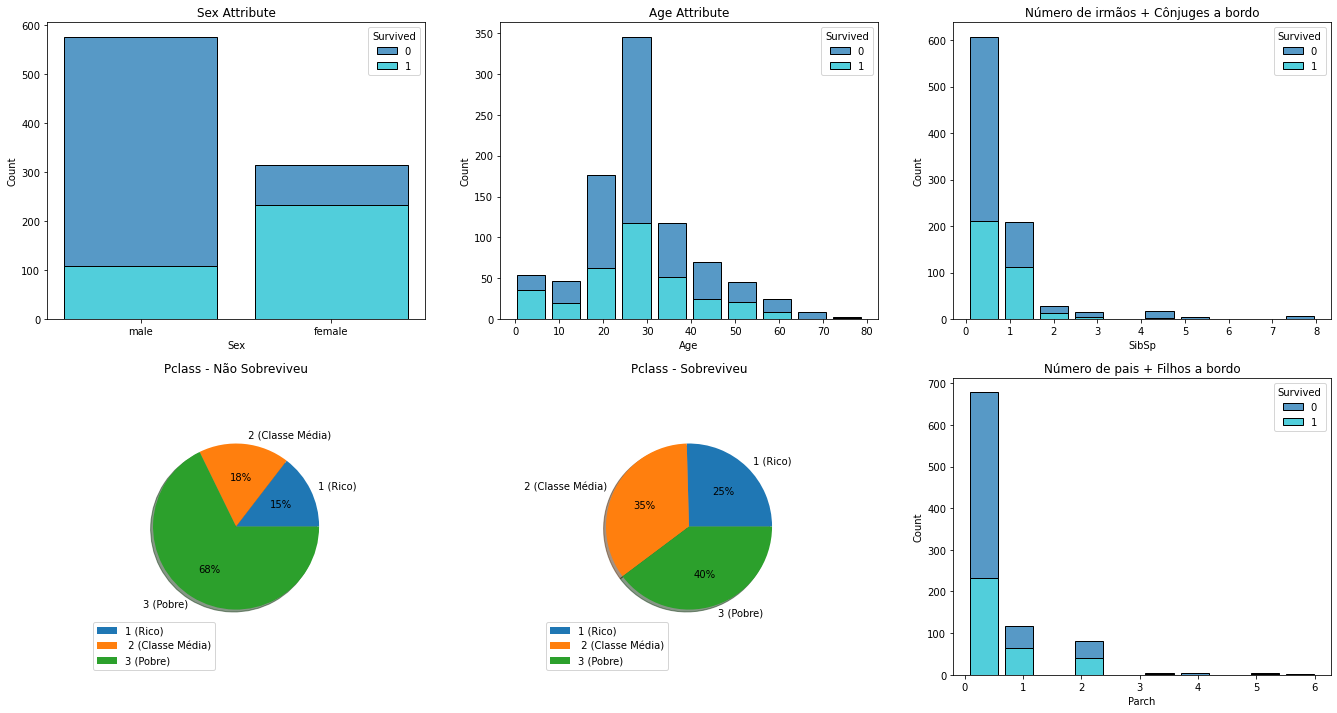

In [26]:
X_imputed_described = X_imputed.copy()
X_imputed_described['Survived'] = df['Survived']

################################################################
# PLOT DE GRÁFICO
################################################################

colors = sns.color_palette()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23, 12))

sns.histplot(data=X_imputed_described, bins=10, x='Sex', hue='Survived', multiple='stack', shrink=0.8, palette=[colors[0], colors[-1]], ax=axes[0][0])
axes[0][0].set_title("Sex Attribute")

sns.histplot(data=X_imputed_described, bins=10, x='Age', hue='Survived', multiple='stack', shrink=0.8, palette=[colors[0], colors[-1]], ax=axes[0][1])
axes[0][1].set_title("Age Attribute")

pie_labels = ['1 (Rico)',' 2 (Classe Média)', '3 (Pobre)']
pie_data_non_survived = list(X_imputed_described.groupby('Survived')['Pclass'].value_counts()[0][::-1])
pie_data_survived = list(X_imputed_described.groupby('Survived')['Pclass'].value_counts()[1][::-1])


axes[1][0].pie(pie_data_non_survived,labels=pie_labels, autopct='%.0f%%', shadow=True, radius=0.7)
axes[1][0].legend(loc='lower left')
axes[1][0].set_title("Pclass - Não Sobreviveu")

axes[1][1].pie(pie_data_survived,labels=pie_labels, autopct='%.0f%%', shadow=True, radius=0.7)
axes[1][1].legend(loc='lower left')
axes[1][1].set_title("Pclass - Sobreviveu")



sns.histplot(data=X_imputed_described, bins=10, x='SibSp', hue='Survived', multiple='stack', shrink=0.8, palette=[colors[0], colors[-1]], ax=axes[0][2])
axes[0][2].set_title("Número de irmãos + Cônjuges a bordo")

sns.histplot(data=X_imputed_described, bins=10, x='Parch', hue='Survived', multiple='stack', shrink=0.8, palette=[colors[0], colors[-1]], ax=axes[1][2])
axes[1][2].set_title("Número de pais + Filhos a bordo")

################################################################
# MOSTRANDO ESTATISTICAS DO DATASET
################################################################
X_imputed_described.groupby('Survived').describe()

#### Considerações

1. A quantidade de homens que morreram no naufrágio foi superior que a quantidade de mulheres.

2. A faixa de idade que mais sobreviveu ao naufrágio foi entre 20 e 35 anos.

3. É possivel notar que a quantidade de parentes a bordo influenciou a sobrevivência das pessoas, ou seja, pessoas sem familires a bordo foi a maioria na contagem dos sobreviventes.

4. Pessoas de classe baixa (Pobres) foi a que teve a maior porcetagem de mortes no naufrágio.

### 4. Normalize os dados de acordo com o que estudamos na aula.

In [ ]:
ss = StandardScaler()
ss.fit(X_imput_ohoe)
X_ss = ss.transform(X_imput_ohoe)
X_ss_df = pd.DataFrame(X_ss)


### 5. Visualize o espaço de características usando a técnica PCA. Isto dará uma idéia da separabilidade das classes a partir dos atributos que você escolheu.

In [ ]:
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_pd_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])
X_ss_pca_pd_df

,PC 0,PC 1
0,-1.915326,0.257012
1,5.279379,-0.730461
2,-0.780854,-1.580538
3,2.680727,0.374809
4,-1.772208,0.973224
...,...,...
886,-1.233163,1.037064
887,2.382554,-1.169890
888,-0.451139,-2.522218
889,2.900417,3.214546


<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

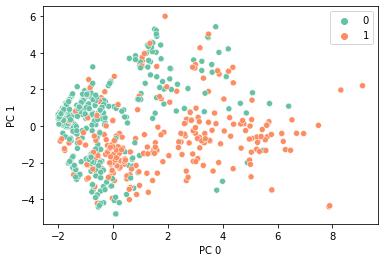

In [ ]:
sns.set_palette('seismic')
sns.scatterplot(data=X_ss_pca_pd_df, x='PC 0', y='PC 1', hue=y, palette='Set2')

### 6. Utilize ambos classificadores estudados até o momento: KNN e SVM. Os hiperparâmetros devem ser selecionados usando o processo de validação cruzada, descrito a seguir.

#### Após realizarmos todos os tratamentos em nossos dados, podemos começar o processo de classificação para treinar e obter nosso melhor modelo

In [ ]:
from do_svm7777 import do_cv_svm
from do_knn7777 import do_cv_knn

svm, best_params_svm = do_cv_svm(X_imput_ohoe, y, 10, 5, params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']}, n_jobs=8)
knn, best_params_knn = do_cv_knn(X_imput_ohoe, y, 10, 5, params={'n_neighbors' : range(1,30,2)}, n_jobs=8)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

#### No código abaixo, construimos um DataFrame Pandas para para conseguirmos visualizar as acurácias de forma simplificada

In [ ]:
target = 'f1-score'
svm_result = []
knn_result = []

for fold in svm:
  svm_result.append([fold['weighted avg'][target], fold['0'][target], fold['1'][target]])

for fold in knn:
  knn_result.append([fold['weighted avg'][target], fold['0'][target], fold['1'][target]])
  
svm_pd_table = pd.DataFrame(svm_result, columns=['Weighted AVG', 'Classe 0', 'Classe 1'])
knn_pd_table = pd.DataFrame(knn_result, columns=['Weighted AVG', 'Classe 0', 'Classe 1'])

knn_classe0_f1_score = knn_pd_table['Classe 0']
knn_classe1_f1_score = knn_pd_table['Classe 1']
knn_f1_score = knn_pd_table['Weighted AVG']

svm_classe0_f1_score = svm_pd_table['Classe 0']
svm_classe1_f1_score = svm_pd_table['Classe 1']
svm_f1_score = svm_pd_table['Weighted AVG']


### 8. Selecione o melhor modelo gerado usando análise estatística do desempenho obtido pelos classificadores durante a validação cruzada. Faça esta seleção de forma automática!

In [ ]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [ ]:
media_knn, std_knn, _, _ = calcular_estatisticas(knn_f1_score)
media_svm, std_svm, _, _ = calcular_estatisticas(svm_f1_score)

_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(knn_f1_score), media_svm, std_svm, len(svm_f1_score))

In [ ]:
pvalor

0.00021279320022076956

In [ ]:
print("Média SVM:", media_svm)
print("Média KNN:", media_knn)

Média SVM: 0.8332785792211169
Média KNN: 0.7546039375021023


In [ ]:
alpha = 0.05
trusty = (1 - alpha)*100
name_best_mean = 'KNN' if (media_knn > media_svm) else 'SVM'
best_mean = max(media_knn, media_svm) 

if(pvalor <= alpha):
  print("\U00002B55 Conclusão, ")
  print("Como nosso ponto de corte (p-value)=%.5f deve ser no máximo alpha=%.5f, ou seja, o nível de confiança deve ser no mínimo %d%%, a hipótese nula será rejeitada \U0000274C." % (pvalor, alpha, trusty))
  print("Sendo assim, concluímos que a média dos classificadores não são estatisticamente equivalentes.")
  print("Desta forma, é valido afirmar que o classificador com a maior média será a melhor escolha para o nosso problema.")
  print("Doravante, o classificador escolhido foi o %s, com a média de %.10f..." % (name_best_mean, best_mean))
else:
  print("\U00002B55 Conclusão,")
  print("Como nosso ponto de corte (p-value)=%.5f é maior que alpha=%.5f, ou seja, não foi atingido o nível de confiança mínima exigido (%d%%), a hipótese nula será aceita \U00002705." % (pvalor, alpha, trusty))
  print("Sendo assim, concluimos que não existe diferença significativa entre as médias dos classificadores, ou seja, os mesmos são equivalentes.")
  print("Doravate, podemos escolher qualquer um dos classificadores para o nosso problema.")
  
  

⭕ Conclusão, 
Como nosso ponto de corte (p-value)=0.00021 deve ser no máximo alpha=0.05000, ou seja, o nível de confiança deve ser no mínimo 95%, a hipótese nula será rejeitada ❌.
Sendo assim, concluímos que a média dos classificadores não são estatisticamente equivalentes.
Desta forma, é valido afirmar que o classificador com a maior média será a melhor escolha para o nosso problema.
Doravante, o classificador escolhido foi o SVM, com a média de 0.8332785792...


### 9. Apresente os resultados da classificação com todos os modelos, apresentando as métricas de classificação por classe e também da classificação como um todo.

### KNN - Tabela Pandas

In [ ]:
knn_pd_table

,Weighted AVG,Classe 0,Classe 1
0,0.774942,0.824561,0.696970
1,0.776410,0.814815,0.714286
2,0.770219,0.827586,0.677419
3,0.782686,0.834783,0.698413
4,0.670963,0.743363,0.553846
5,0.761732,0.814159,0.676923
6,0.761732,0.814159,0.676923
7,0.765722,0.803738,0.704225
8,0.752809,0.800000,0.676471
9,0.728823,0.781818,0.647059


### Estatisticas KNN

In [ ]:
print("KNN F1-SCORE - CLASSE 0")
imprimir_estatisticas(knn_classe0_f1_score)
print()


print("KNN F1-SCORE - CLASSE 1")
imprimir_estatisticas(knn_classe1_f1_score)
print()


print("KNN F1-SCORE")
imprimir_estatisticas(knn_f1_score)
print()


KNN F1-SCORE - CLASSE 0
Resultados: 0.81 +- 0.03, min: 0.74, max: 0.83

KNN F1-SCORE - CLASSE 1
Resultados: 0.67 +- 0.04, min: 0.55, max: 0.71

KNN F1-SCORE
Resultados: 0.75 +- 0.03, min: 0.67, max: 0.78



### SVM - Tabela Pandas

In [ ]:
svm_pd_table

,Weighted AVG,Classe 0,Classe 1
0,0.798845,0.839286,0.735294
1,0.852501,0.884956,0.800000
2,0.794981,0.842105,0.718750
3,0.932584,0.945455,0.911765
4,0.796494,0.839286,0.727273
5,0.862131,0.896552,0.806452
6,0.772201,0.824561,0.687500
7,0.830962,0.864865,0.776119
8,0.840541,0.877193,0.781250
9,0.851546,0.884956,0.800000


### Estatisticas SVM

In [ ]:
print("SVM F1-SCORE - CLASSE 0")
imprimir_estatisticas(svm_classe0_f1_score)
print()

print("SVM F1-SCORE - CLASSE 1")
imprimir_estatisticas(svm_classe1_f1_score)
print()


print("SVM F1-SCORE")
imprimir_estatisticas(svm_f1_score)
print()


SVM F1-SCORE - CLASSE 0
Resultados: 0.87 +- 0.03, min: 0.82, max: 0.95

SVM F1-SCORE - CLASSE 1
Resultados: 0.77 +- 0.06, min: 0.69, max: 0.91

SVM F1-SCORE
Resultados: 0.83 +- 0.04, min: 0.77, max: 0.93



### Conclusão

#### Sendo assim, com base na média da classificação como um todo, afirmo que o modelo treinado utilizando o classificador SVM é melhor que o treinado com o KNN